# Q1

In [2]:
import numpy as np
import sympy as sp 
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple, List

%matplotlib inline

In [3]:
# Initialize the data (in inches)

# Problem 1
FIXED_DC = 7.0
INPUT_DA = 1.94
COUPLER_AB = 6.86
OUTPUT_CB = 2.36

# Problem 2
FIXED_CG = 1.25
INPUT_CE = 2.39
COUPLER_EF = 1.87
OUTPUT_GF = 1.26

In [4]:
def get_theta2_and_theta3(
        theta: np.float64,
        r4_input: np.float64,
        r3_coupler: np.float64,
        r2_output: np.float64,
        r1_fixed: np.float64,
        initial_guess: List[np.float64],
        tol: np.float64 = 1e-4,
        max_iter: np.float64 = 1000
):
    theta4 = 180 + theta
    theta4 = np.deg2rad(theta4)

    theta2, theta3 = sp.symbols('theta2 theta3')

    f1 = r2_output * sp.cos(theta2) + r3_coupler * sp.cos(theta3) + r4_input * sp.cos(theta4) - r1_fixed
    f2 = r2_output * sp.sin(theta2) + r3_coupler * sp.sin(theta3) + r4_input * sp.sin(theta4)

    F = sp.Matrix([f1, f2])
    J = F.jacobian([theta2, theta3])

    F_func = sp.lambdify((theta2, theta3), F, 'numpy')
    J_func = sp.lambdify((theta2, theta3), J, 'numpy')

    curr_theta = np.deg2rad(initial_guess)
    for i in range(1, max_iter+1):
        F_val = np.array(F_func(curr_theta[0], curr_theta[1]), dtype=np.float64).flatten()
        J_val = np.array(J_func(curr_theta[0], curr_theta[1]), dtype=np.float64)

        delta_theta = np.linalg.solve(J_val, -F_val)
        curr_theta = curr_theta + delta_theta

        if np.linalg.norm(delta_theta, ord=2) / np.linalg.norm(curr_theta, ord=2) < tol:
            break
    
    curr_theta = np.rad2deg(curr_theta)

    return curr_theta[0], curr_theta[1]

## Sanity check
r1, r2, r3, r4 = 10, 6, 8, 4
phi, psi = get_theta2_and_theta3(40, r4, r3, r2, r1, [30,0])
print(phi, psi)


32.01518035932675 -4.370987405000886


Calculating $\phi$ Values:   0%|          | 0/360 [00:00<?, ?it/s]

Calculating $\phi$ Values: 100%|██████████| 360/360 [00:03<00:00, 101.45it/s]


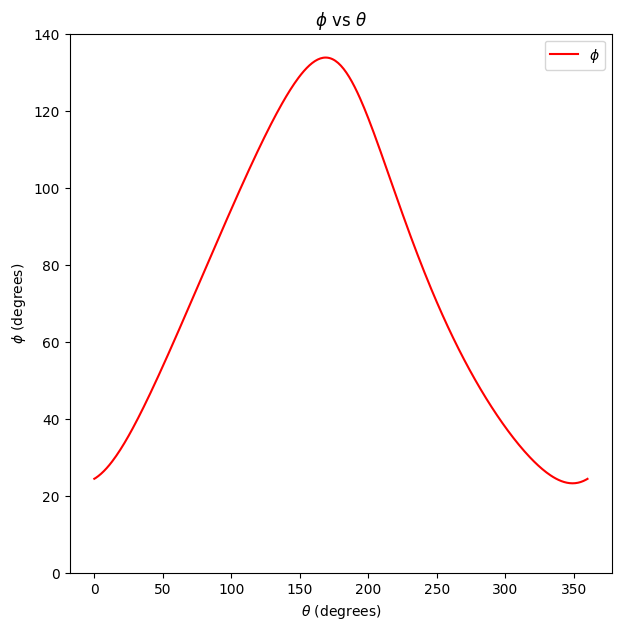

In [5]:
theta_values = np.linspace(0, 360, 361)

phi_values = np.zeros_like(theta_values)
psi_values = np.zeros_like(theta_values)
phi, psi = get_theta2_and_theta3(0, INPUT_DA, COUPLER_AB, OUTPUT_CB, FIXED_DC, [45, 60])
phi_values[0] = phi 
psi_values[0] = psi 

for i in tqdm(range(1, 361), desc= r'Calculating $\phi$ Values'):
    phi, psi = get_theta2_and_theta3(
        theta_values[i], INPUT_DA, COUPLER_AB, OUTPUT_CB, FIXED_DC, [phi_values[i-1], psi_values[i-1]]
    )
    phi_values[i] = phi
    psi_values[i] = psi

phi_values = phi_values % 360
psi_values = psi_values % 360

plt.figure(figsize=(7,7))
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\phi$ (degrees)')
plt.plot(theta_values, phi_values, label=r'$\phi$', color='red')
plt.title(r'$\phi$ vs $\theta$')
plt.ylim(0, 140)
plt.legend()
plt.show()

In [6]:
def fw_diff(x, y):
    n = len(y)
    forward_difference = np.zeros_like(y)
    for i in range(n-1):
        forward_difference[i] = (y[i+1] - y[i])/(x[i+1] - x[i])
    forward_difference[-1] = (y[-1] - y[-2])/(x[-1] - x[-2])
    return forward_difference


def center_diff(x, y):
    n = len(y)
    centered_difference = np.zeros_like(y)
    for i in range(1, n-1):
        centered_difference[i] = (y[i+1] - y[i-1])/(x[i+1] - x[i-1])
    centered_difference[0] = (y[1] - y[0])/(x[1] - x[0])
    centered_difference[-1] = (y[-1] - y[-2])/(x[-1] - x[-2])
    return centered_difference

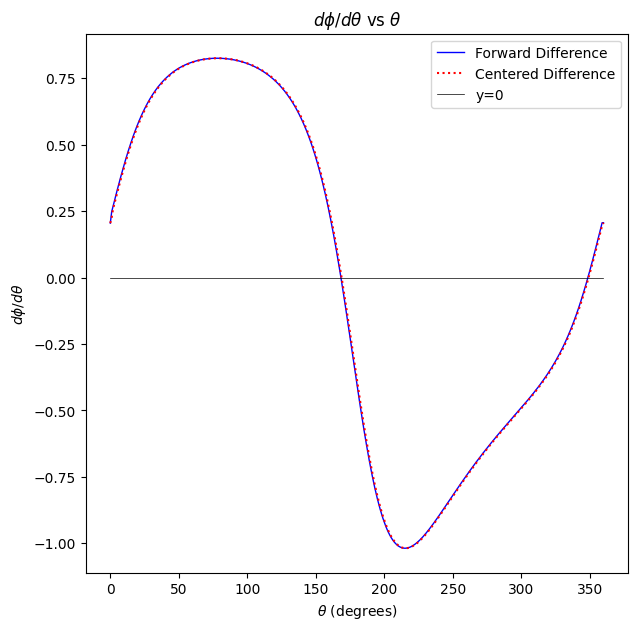

In [7]:
forward_difference = fw_diff(theta_values, phi_values)
centered_difference = center_diff(theta_values, phi_values)

plt.figure(figsize=(7,7))
plt.plot(theta_values, forward_difference, label='Forward Difference', color='blue', linewidth = 1)
plt.plot(theta_values, centered_difference, label='Centered Difference', color='red', linestyle= ':')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$d\phi/d\theta$')
plt.title(r'$d\phi/d\theta$ vs $\theta$')
plt.plot(theta_values, np.zeros_like(theta_values), color='black', linewidth = 0.5, label='y=0')
plt.plot
plt.legend()


Max $\Delta$ : 0.021400541858383804
Inital Delta : 0.017453292519943295


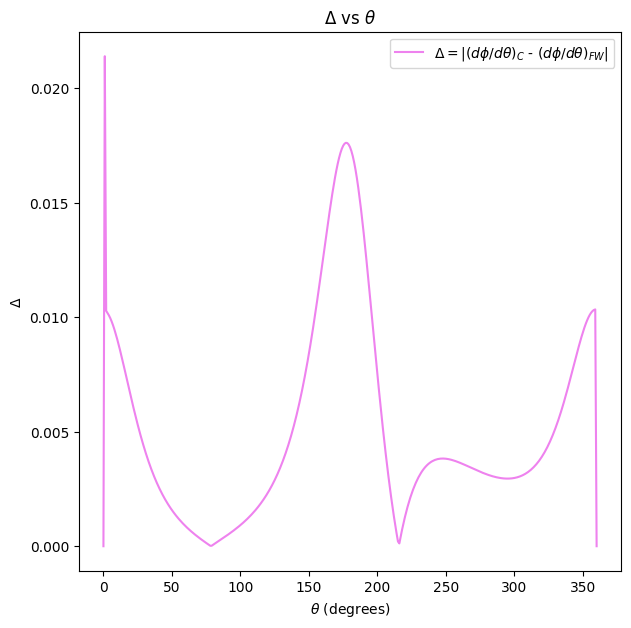

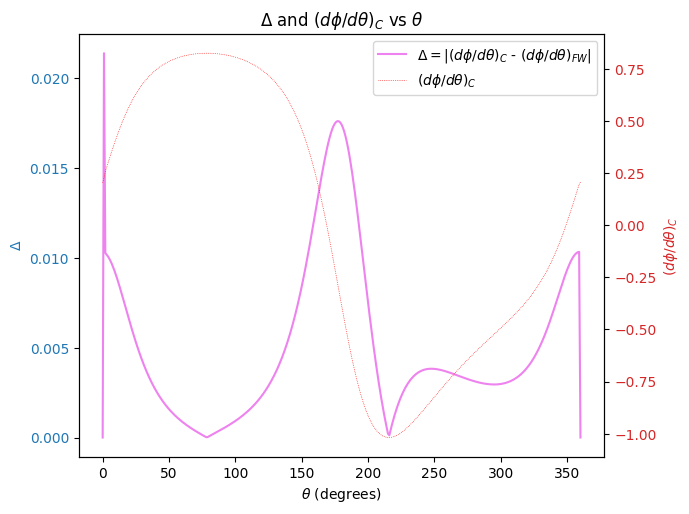

In [8]:
difference = np.abs(forward_difference - centered_difference)
print(f"Max $\Delta$ : {max(difference)}") 
print(f"Inital Delta : {(np.deg2rad(1))}")
plt.figure(figsize=(7,7))
plt.plot(theta_values, difference, label=r"$\Delta = $$|(d\phi/d\theta)_{C}$ - $(d\phi/d\theta)_{FW}|$", color='violet')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\Delta$')
plt.title(r'$\Delta$ vs $\theta$')
plt.legend()
plt.show()

fig, ax1 = plt.subplots(figsize=(7,5))

color = 'tab:blue'
ax1.set_xlabel(r'$\theta$ (degrees)')
ax1.set_ylabel(r'$\Delta$', color=color)
ax1.plot(theta_values, difference, label=r"$\Delta = $$|(d\phi/d\theta)_{C}$ - $(d\phi/d\theta)_{FW}|$", color='violet' )
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'$(d\phi/d\theta)_{C}$', color=color)
ax2.plot(theta_values, centered_difference, label=r'$(d\phi/d\theta)_{C}$', color='red', linestyle = ':', linewidth = 0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(r'$\Delta$ and $(d\phi/d\theta)_{C}$ vs $\theta$')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

solving for beta: 100%|██████████| 360/360 [00:03<00:00, 101.67it/s]


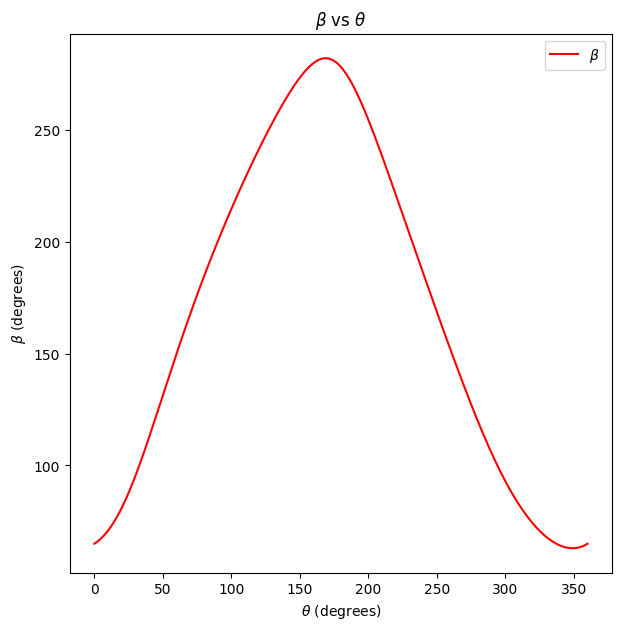

In [9]:
alpha_values = phi_values + 149
beta_values = np.zeros_like(alpha_values)
beta_psi_values = np.zeros_like(alpha_values)

beta0, beta_psi0 = get_theta2_and_theta3(
        alpha_values[0], INPUT_CE, COUPLER_EF, OUTPUT_GF, FIXED_CG, [30, 270]
    )

beta_values[0] = beta0 % 360 
beta_psi_values[0] = beta_psi0


for i in tqdm(range(1, 361), desc= "solving for beta"):
    
    beta0, beta_psi0 = get_theta2_and_theta3(
    alpha_values[i], INPUT_CE, COUPLER_EF, OUTPUT_GF, FIXED_CG, [beta_values[i-1], beta_psi_values[i-1]]
    )
    beta_values[i] = beta0 % 360
    beta_psi_values[i] = beta_psi0 % 360

beta_values = beta_values % 360
beta_psi_values = beta_psi_values % 360
plt.figure(figsize=(7,7))
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\beta$ (degrees)')
plt.plot(theta_values, beta_values, label=r'$\beta$', color='red')
plt.title(r'$\beta$ vs $\theta$')
plt.legend()
plt.show() 

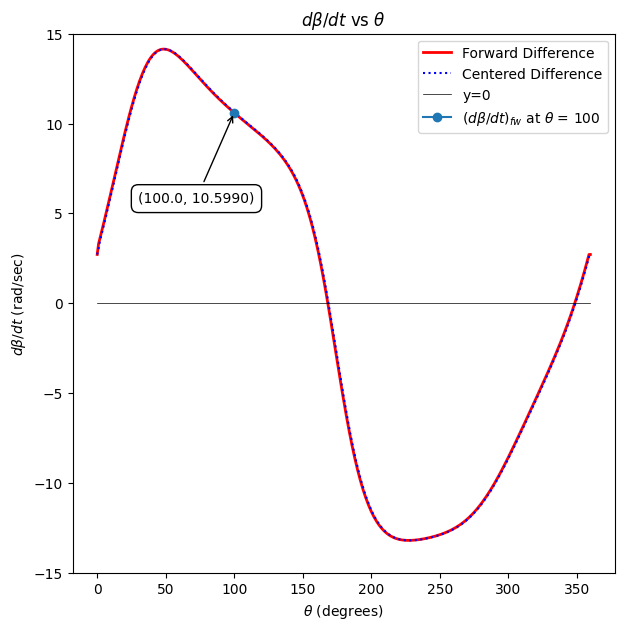

In [10]:
omega = 450 / 60 #rad/sec


beta_values_rad = np.deg2rad(beta_values)
theta_values_rad = np.deg2rad(theta_values)

dbeta_by_dt_fw = fw_diff(theta_values_rad, beta_values_rad)*omega
dbeta_by_dt_center = center_diff(theta_values_rad, beta_values_rad)*omega

plt.figure(figsize=(7,7))
plt.plot(theta_values, dbeta_by_dt_fw, label='Forward Difference', color='red', linewidth = 2)
plt.plot(theta_values, dbeta_by_dt_center, label='Centered Difference', color='blue', linestyle= ':')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$d\beta/dt$ (rad/sec)')
plt.title(r'$d\beta/dt$ vs $\theta$')
plt.plot(theta_values, np.zeros_like(theta_values), color='black', linewidth = 0.5, label='y=0')
plt.plot(theta_values[100], dbeta_by_dt_fw[100], marker='o', label=r"$(d\beta/dt)_{fw}$ at $\theta$ = 100 ")
plt.annotate(f'({theta_values[100]}, {dbeta_by_dt_fw[100]:.4f})',
             xy=(theta_values[100], dbeta_by_dt_fw[100]), 
             xytext=(theta_values[100] - 70 , dbeta_by_dt_fw[100] - 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), )
plt.ylim((-15,15))
plt.legend()
plt.show()

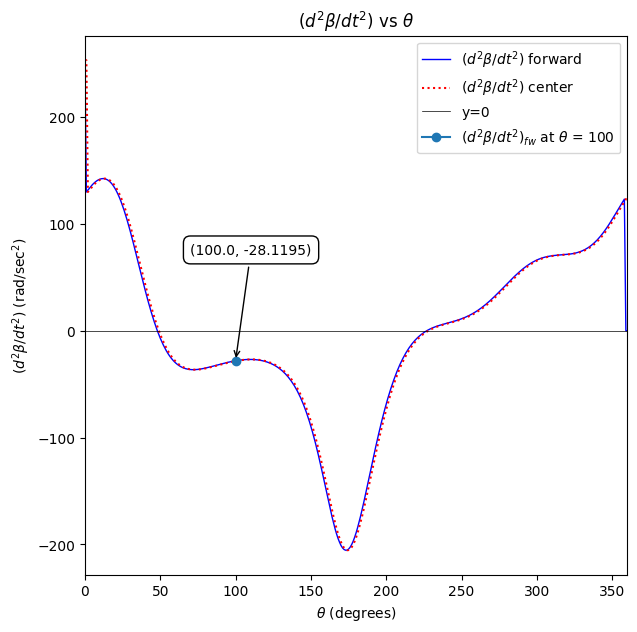

In [11]:
dbeta2_by_dt2_fw = fw_diff(theta_values_rad, fw_diff(theta_values_rad, beta_values_rad))*omega**2

def second_center_diff(x, y):
    n = len(y)
    second_diff = np.zeros_like(y)
    for i in range(1, n-1):
        second_diff[i] = (y[i+1] - 2*y[i] + y[i-1]) / ((x[i+1] - x[i])**2)
    # For boundary points, we can use forward/backward difference
    second_diff[0] = (y[2] - 2*y[1] + y[0]) / ((x[1] - x[0])**2)
    second_diff[-1] = (y[-1] - 2*y[-2] + y[-3]) / ((x[-1] - x[-2])**2)
    return second_diff

dbeta2_by_dt2_center = second_center_diff(theta_values_rad, beta_values_rad)*omega**2

plt.figure(figsize=(7, 7))
plt.plot(theta_values, dbeta2_by_dt2_fw, label=r'$(d^2\beta/dt^2)$ forward', color='blue', linewidth = 1)
plt.plot(theta_values, dbeta2_by_dt2_center, label=r'$(d^2\beta/dt^2)$ center', color='red', linestyle= ':')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$(d^2\beta/dt^2)$ (rad/sec$^2$)')
plt.title(r'$(d^2\beta/dt^2)$ vs $\theta$')
plt.plot(theta_values, np.zeros_like(theta_values), color='black', linewidth = 0.5, label='y=0')
plt.plot(theta_values[100], dbeta2_by_dt2_fw[100], marker='o', label=r"$(d^{2}\beta/dt^{2})_{fw}$ at $\theta$ = 100")
plt.annotate(f'({theta_values[100]}, {dbeta2_by_dt2_fw[100]:.4f})',
             xy=(theta_values[100], dbeta2_by_dt2_fw[100]), 
             xytext=(theta_values[100] - 30 , dbeta2_by_dt2_fw[100] +100),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), )
plt.xlim(0,360)
plt.legend()
plt.show()


In [12]:
print(f"fw angular vel {dbeta_by_dt_fw[100]}")
print(f"center angular vel {dbeta_by_dt_center[100]}")
print(f"fw Angular Acceleration {dbeta2_by_dt2_fw[100]}")
print(f"center Angular Acceleration {dbeta2_by_dt2_center[100]}")


fw angular vel 10.598973694966679
center angular vel 10.631983008702935
fw Angular Acceleration -28.119477713125956
center Angular Acceleration -28.369415425660396


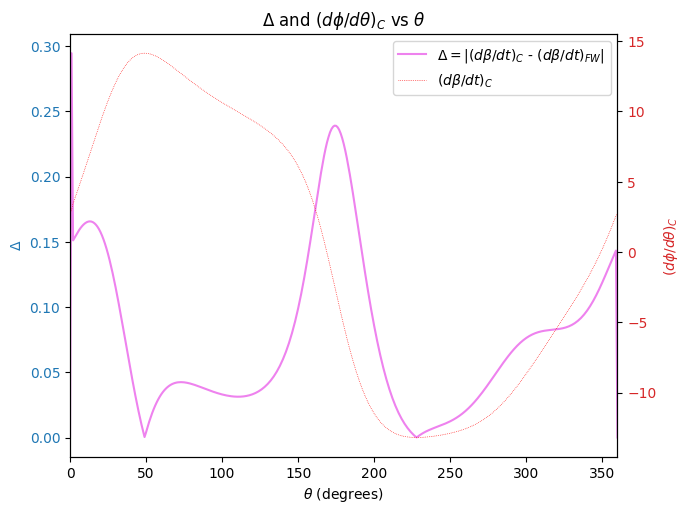

In [20]:
fig, ax1 = plt.subplots(figsize=(7,5))

difference_db_dt = np.abs(dbeta_by_dt_center - dbeta_by_dt_fw)

color = 'tab:blue'
ax1.set_xlabel(r'$\theta$ (degrees)')
ax1.set_ylabel(r'$\Delta$', color=color)
ax1.plot(theta_values, difference_db_dt, label=r"$\Delta = $$|(d\beta/dt)_{C}$ - $(d\beta/dt)_{FW}|$", color='violet' )
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'$(d\phi/d\theta)_{C}$', color=color)
ax2.plot(theta_values, dbeta_by_dt_center, label=r'$(d\beta/dt)_{C}$', color='red', linestyle = ':', linewidth = 0.5)
ax2.tick_params(axis='y', labelcolor=color)

plt.xlim((0,360))
fig.tight_layout()
plt.title(r'$\Delta$ and $(d\phi/d\theta)_{C}$ vs $\theta$')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

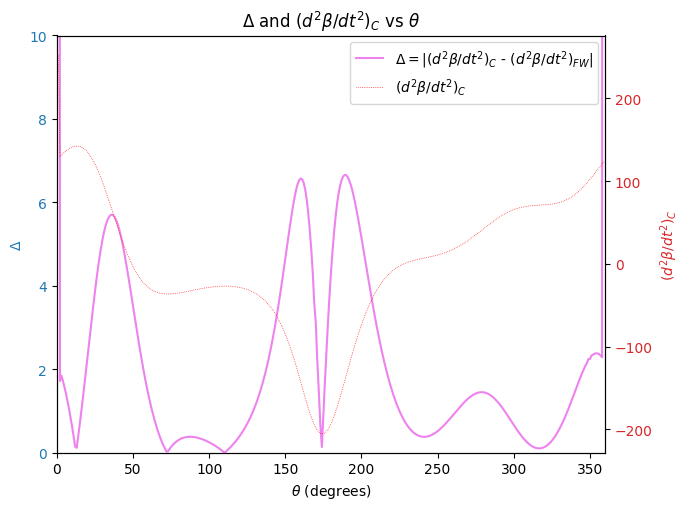

In [21]:
fig, ax1 = plt.subplots(figsize=(7,5))

difference_d2b_dt2 = np.abs(dbeta2_by_dt2_center - dbeta2_by_dt2_fw)

color = 'tab:blue'
ax1.set_xlabel(r'$\theta$ (degrees)')
ax1.set_ylabel(r'$\Delta$', color=color)
ax1.plot(theta_values, difference_d2b_dt2, label=r"$\Delta = $$|(d^2\beta/dt^2)_{C}$ - $(d^2\beta/dt^2)_{FW}|$", color='violet' )
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim((0,10))

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'$(d^2\beta/dt^2)_{C}$', color=color)
ax2.plot(theta_values, dbeta2_by_dt2_center, label=r'$(d^2\beta/dt^2)_{C}$', color='red', linestyle = ':', linewidth = 0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(r'$\Delta$ and $(d^2\beta/dt^2)_{C}$ vs $\theta$')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.xlim((0,360))
plt.show()